In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the patient data
_data = np.load('data/re_intubation.npy', allow_pickle=True).tolist()
patients = _data['patients']
print("Loaded!")

Loaded!


In [3]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [4]:
# Load the appropriate query
query = open('queries/palliative.sql', 'r')

# Store the result of the query as a pandas dataframe
palliative = pd.read_sql_query(query.read(), conn)
query.close()

In [5]:
# Add a column describing if the patient has ever gotten DNR/DNI status
patients = patients.merge(palliative[['icustay_id', 'palliativetime', 'palliativeatdisch', 'palliative']], how='left', on='icustay_id')

In [6]:
# Define weaning success
patients['weaning_success'] = ((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['hospital_expire_flag']==0) # weaning success if survived and never re-intubated or re-intubated 5 days post-extubation

# Define weaning failure
patients['die_72hrs_post_ext'] = (patients['dischtime'].subtract(patients['endtime'].astype('datetime64')) < np.timedelta64(1, 'D')) & (patients['hospital_expire_flag']==1)
patients['weaning_failure'] = (patients['failure']==True) | (((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1)) # weaning failure if re-intubated less than 72 hours post-extubation, or if patient dies less than 72 hours post-extubation with a DNR/DNI order

# Select only patients that meet weaning success or failure criteria
final_patients = patients[(patients['weaning_success']==1) | (patients['weaning_failure']==1)]

# Show some sample data
final_patients.head()

,subject_id,hadm_id,icustay_id,gender,dob,age,admittime,dischtime,intime,outtime,...,duration_hours,never_reintubated,reintubated_after_5_days,failure,palliativetime,palliativeatdisch,palliative,weaning_success,die_72hrs_post_ext,weaning_failure
0,268,110404,280836,F,2132-02-21,65.98,2198-02-11 13:40:00,2198-02-18 03:55:00,2198-02-14 23:27:38,2198-02-18 05:26:11,...,62,True,False,False,2198-02-17 18:00:00,1.0,1.0,False,True,True
2,283,109185,231490,M,2090-09-05,75.93,2166-08-12 22:02:00,2166-09-12 14:41:00,2166-08-12 22:03:26,2166-09-12 14:41:42,...,702,False,False,True,2166-08-18 14:00:00,1.0,1.0,False,False,True
3,285,165312,238023,M,2107-05-16,45.35,2152-09-21 22:47:00,2152-10-20 15:19:00,2152-09-21 22:48:50,2152-10-20 15:19:31,...,667,True,False,False,NaT,NaN,NaN,True,False,False
4,286,106909,260225,F,2090-12-25,85.01,2175-12-31 22:56:00,2176-02-24 16:23:00,2175-12-31 22:57:27,2176-02-24 19:16:58,...,778,False,False,True,NaT,NaN,NaN,False,False,True
5,290,138303,278519,M,2104-09-08,74.38,2179-01-26 07:15:00,2179-02-08 17:30:00,2179-01-26 19:27:19,2179-01-31 11:37:31,...,60,True,False,False,NaT,NaN,NaN,True,False,False


In [7]:
print("Starting number of patients in dataset:")
print("")
print("len(patients): {}".format(len(patients)))
print("")
print("")
print("")
print("Weaning success criteria:")
print("")
print("patients['never_reintubated']==True: {}".format(sum(patients['never_reintubated']==True)))
print("patients['reintubated_after_5_days']==True: {}".format(sum(patients['reintubated_after_5_days']==True)))
print("patients['hospital_expire_flag']==0: {}".format(sum(patients['hospital_expire_flag']==0)))
print("")
print("((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['hospital_expire_flag']==0): {}".format(sum(((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['hospital_expire_flag']==0))))
print("")
print("")
print("")
print("Weaning failure criteria:")
print("")
print("(patients['failure']==True): {}".format(sum((patients['failure']==True))))
print("")
print("(patients['die_72hrs_post_ext']==True): {}".format(sum(patients['die_72hrs_post_ext']==True)))
print("(patients['palliative']==1): {}".format(sum((patients['palliative']==1))))
print("")
print("((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1): {}".format(sum(((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1))))
print("")
print("(patients['failure']==True) | (((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1)): {}".format(sum((patients['failure']==True) | (((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1)))))

Starting number of patients in dataset:

len(patients): 10629



Weaning success criteria:

patients['never_reintubated']==True: 7865
patients['reintubated_after_5_days']==True: 147
patients['hospital_expire_flag']==0: 7770

((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['hospital_expire_flag']==0): 5685



Weaning failure criteria:

(patients['failure']==True): 2481

(patients['die_72hrs_post_ext']==True): 1747
(patients['palliative']==1): 1732

((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1): 800

(patients['failure']==True) | (((patients['never_reintubated']==True) | (patients['reintubated_after_5_days']==True)) & (patients['die_72hrs_post_ext']==True) & (patients['palliative']==1)): 3281


In [8]:
# Print some statistics
print('Total number of patients: {}'.format(len(final_patients)))
print('Successful extubations: {} ({:.1f}%)'.format(sum(final_patients['weaning_success']), 100*sum(final_patients['weaning_success'])/len(final_patients)))
print('Extubation failures: {} ({:.1f}%)'.format(sum(final_patients['weaning_failure']), 100*sum(final_patients['weaning_failure'])/len(final_patients)))

Total number of patients: 8966
Successful extubations: 5685 (63.4%)
Extubation failures: 3281 (36.6%)


In [9]:
# Save to final_patients.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {'patients': final_patients}
np.save('data/final_patients.npy',tosave)
print("Saved!")

Saved!


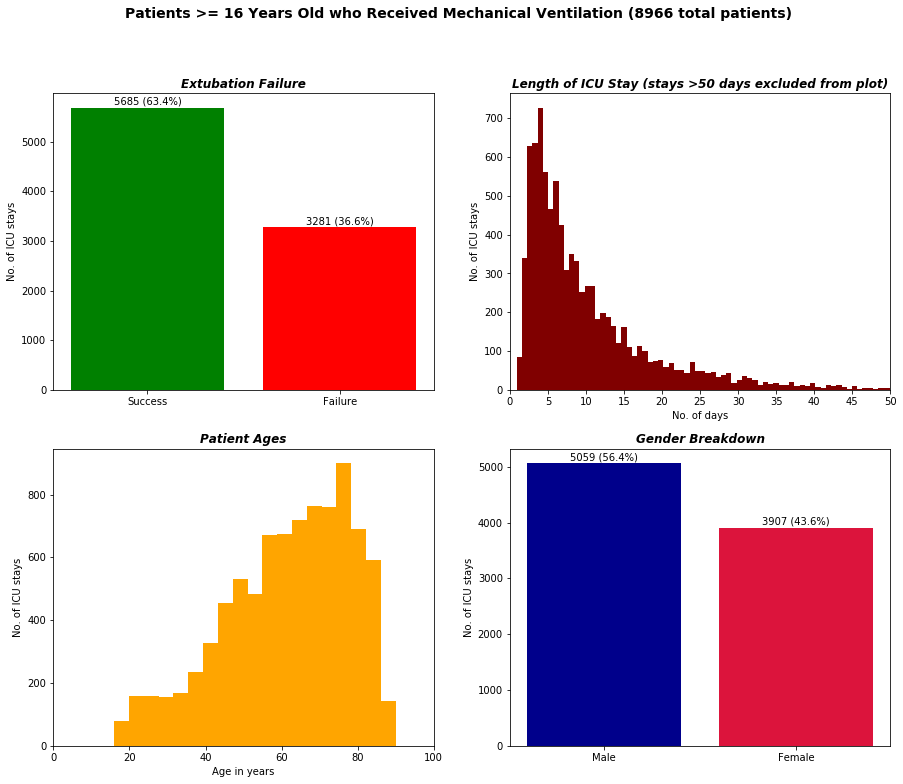

In [10]:
# Visualise mortality rate,length of ICU stay, age and gender
fig, axs = plt.subplots(2, 2, figsize=(15,12))
fig.suptitle('Patients >= 16 Years Old who Received Mechanical Ventilation ({} total patients)'.format(len(final_patients)), weight='semibold', fontsize=14)

# Plot the mortality
bar1 = axs[0,0].bar(x=['Success','Failure'], height=[len(final_patients[final_patients['weaning_success']==True]),len(final_patients[final_patients['weaning_failure']==True])], color=['g','r'])
axs[0,0].set_title('Extubation Failure', style='italic', weight='semibold')
axs[0,0].set_ylabel('No. of ICU stays')

# Plot the length of stay
axs[0,1].hist(x=final_patients['los'], bins=250, color='maroon')
axs[0,1].set_title('Length of ICU Stay (stays >50 days excluded from plot)', style='italic', weight='semibold')
axs[0,1].set_xlim([0,50])
axs[0,1].set_xticks(range(0,51,5))
axs[0,1].set_xlabel('No. of days')
axs[0,1].set_ylabel('No. of ICU stays')

# Plot the patient ages
axs[1,0].hist(x=final_patients['age'].astype('int64'), bins=75, color='orange')
axs[1,0].set_title('Patient Ages', style='italic', weight='semibold')
axs[1,0].set_xlim([0,100])
axs[1,0].set_xlabel('Age in years')
axs[1,0].set_ylabel('No. of ICU stays')

# Plot the gender breakdown
bar2 = axs[1,1].bar(x=['Male','Female'], height=[sum(final_patients['gender']=='M'),sum(final_patients['gender']=='F')], color=['darkblue','crimson'])
axs[1,1].set_title('Gender Breakdown', style='italic', weight='semibold')
axs[1,1].set_ylabel('No. of ICU stays')

# Add a text label above bars in bar chart
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    if rects==bar1:
        ax = axs[0,0]
    elif rects==bar2:
        ax = axs[1,1]
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{} ({:.1f}%)'.format(height, 100*height/len(final_patients)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 2 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

# Save the plot
plt.savefig('plots/final_patients.png');